# RDS HW3 Template

Install the Data Synthesizer library.

# Section

In [1]:
!pip install DataSynthesizer

In [2]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']

    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [4]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']

    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [5]:
def generate_data_CD(input_data_file, output_data_size, description_file, epsilon=0.5, k=1, seed=None):
    seed = seed or randint(0, 2**30)

    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'], epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_xyz__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [6]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# Please follow the steps as instructed when you run the following commands.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas})
downloaded.GetContentFile(real_data_file)
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake})
downloaded.GetContentFile(fake_data_file)
df_fake = pd.read_csv(fake_data_file)

In [8]:
output_data_size = 10000
epsilon = 0.1

seed = 0  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json',
                     'B': './descrption_B.json',
                     'C': './descrption_C.json',
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

clear_output()

## Part (a)

### Q1

Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D, compare to the ground truth value in __hw_compas__, present results in a table

In [9]:
# Your code here
# Calculate statistics for each DataFrame
comparison_dfs_a_q1 = [df_real,df_real_A, df_real_B, df_real_C, df_real_D]
stats_a_q1 = {}
for df_name, df in zip(['Ground Truth', 'A', 'B', 'C', 'D'], comparison_dfs_a_q1):
    stats_a_q1[df_name] = {
        'age_median': df['age'].median(),
        'age_mean': df['age'].mean(),
        'age_min': df['age'].min(),
        'age_max': df['age'].max(),
        'score_median': df['score'].median(),
        'score_mean': df['score'].mean(),
        'score_min': df['score'].min(),
        'score_max': df['score'].max(),
    }

# Create a DataFrame to display the results
stats_df_a_q1 = pd.DataFrame(stats_a_q1).T

# Display the table
stats_df_a_q1

,age_median,age_mean,age_min,age_max,score_median,score_mean,score_min,score_max
Ground Truth,32.0,35.143319,18.0,96.0,4.0,4.371268,-1.0,10.0
A,51.0,50.173100,0.0,100.0,5.0,4.939200,-1.0,10.0
B,33.0,35.735400,18.0,76.0,4.0,4.365700,1.0,10.0
C,36.0,41.578800,18.0,96.0,5.0,4.948700,-1.0,10.0
D,39.0,44.153200,18.0,96.0,4.0,4.466000,-1.0,10.0


### Q2

Some more sophisticated statistical measure that’s good for independent attribute mode - __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__. Also show the difference visually, comparing real vs. synthetic

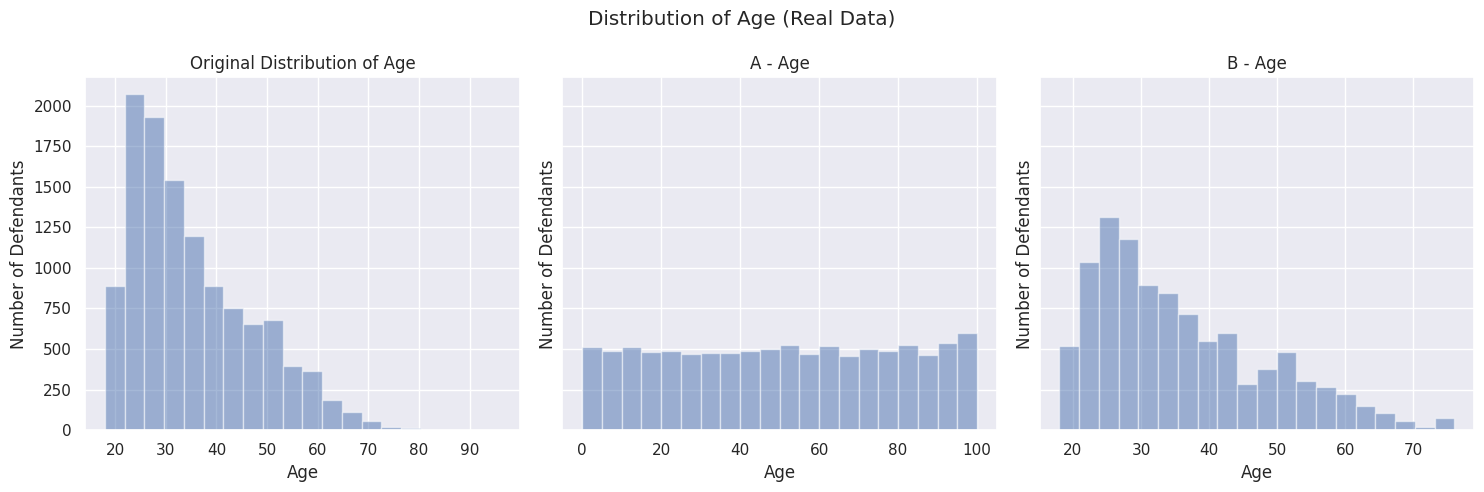

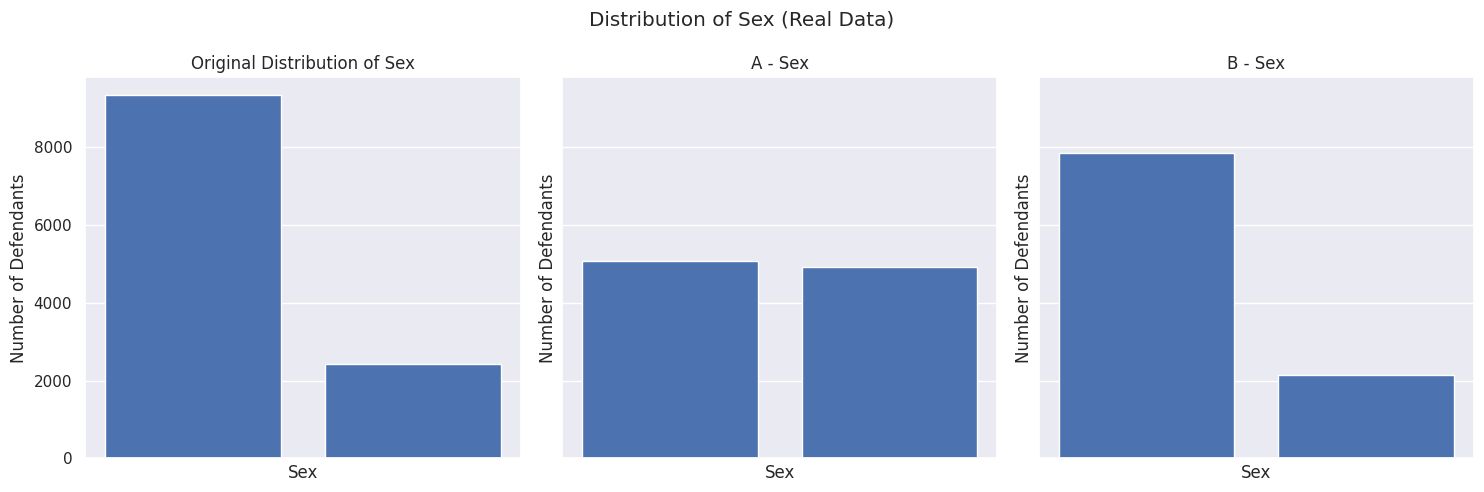

In [10]:
# Your code here
comparisons_a_q2 = [df_real,df_real_A, df_real_B]
age_titles_a_q2 = ['Original Distribution of Age', 'A - Age', 'B - Age']
sex_titles_a_q2 = ['Original Distribution of Sex', 'A - Sex', 'B - Sex']

# Age plots
fig1, axs1 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig1.subplots_adjust(hspace=0.5, wspace=0.5)
fig1.suptitle('Distribution of Age (Real Data)')

for i, df in enumerate(comparisons_a_q2):
    ax = axs1.flatten()[i]
    ax.hist(df['age'], bins=20, alpha=0.5)
    ax.set_title(age_titles_a_q2[i])
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of Defendants')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Sex plots
fig2, axs2 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig2.subplots_adjust(hspace=0.5, wspace=0.5)
fig2.suptitle('Distribution of Sex (Real Data)')

for i, df in enumerate(comparisons_a_q2):
    ax = axs2.flatten()[i]
    ax.hist(df['sex'], bins=2, rwidth=0.8)
    ax.set_title(sex_titles_a_q2[i])
    ax.set_xlabel('Sex')
    ax.set_ylabel('Number of Defendants')
    ax.grid(True)

plt.tight_layout()
plt.show()

#### Two-sample Kolmogorov–Smirnov test for continous attributes

In [11]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

#### KL-divergence for categorical attributes

In [12]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [13]:
KS_A = ks_test(df_real, df_real_A, 'age')
KS_B = ks_test(df_real, df_real_B, 'age')
KL_A = kl_test(df_real, df_real_A, 'sex')
KL_B = kl_test(df_real, df_real_B, 'sex')
print(f"KS test for age for original vs. A: {KS_A}")
print(f"KS test for age for original vs. B: {KS_B}")
print(f"KL test for sex for original vs. A: {KL_A}")
print(f"KL test for sex for original vs. B: {KL_B}")

KS test for age for original vs. A: 0.3735091775112699
KS test for age for original vs. B: 0.026252445351705345
KL test for sex for original vs. A: 0.22319792405369002
KL test for sex for original vs. B: 0.0002494300869420041


### Q3

some more sophisticated statistical measure that’s good for correlated attribute mode, and will be better with k=2 (case D) than with k=1 (case C), __some distance over pairwise correlation coefficients? Also show the difference visually, comparing results on real vs. synthetic datasets__.

In [14]:
# Use pairwise_attributes_mutual_information function.
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31
# Your code here
mi_fake = pairwise_attributes_mutual_information(df_fake)
mi_fake_C = pairwise_attributes_mutual_information(df_fake_C)
mi_fake_D = pairwise_attributes_mutual_information(df_fake_D)

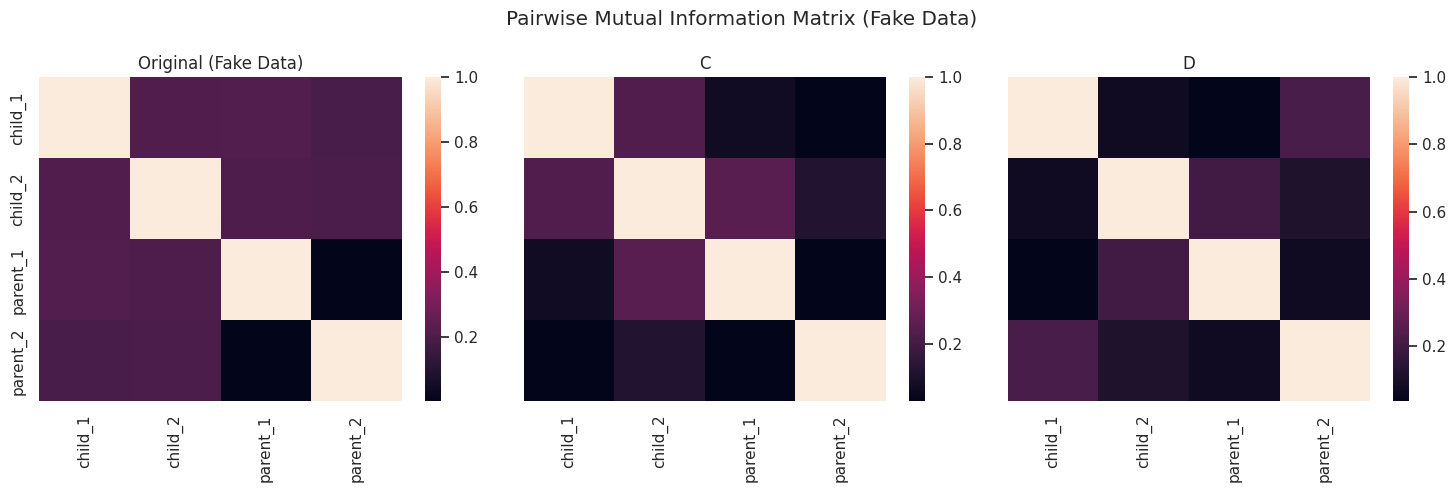

In [15]:
# Use can sns.heatmap for pairwise mutual information
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.heatmap.html
# Your code here
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Pairwise Mutual Information Matrix (Fake Data)')
sns.heatmap(mi_fake, ax=axs[0])
axs[0].set_title('Original (Fake Data)')
sns.heatmap(mi_fake_C, ax=axs[1])
axs[1].set_title('C')
sns.heatmap(mi_fake_D, ax=axs[2])
axs[2].set_title('D')
plt.tight_layout()
plt.show()

## Part (b)

Study the variability in accuracy of answers to Q1 and Q2 for A, B and C: fix epsilon = 0.1, generate __10__ synthetic databases (by specifying different seeds).  Plot accuracy as a box-and-whiskers plot.  

In [16]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html
# Your code here

random_seeds = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
column_names_b = ['median_A', 'mean_A', 'min_A', 'max_A', 'median_B', 'mean_B', 'min_B', 'max_B', 'median_C', 'mean_C', 'min_C', 'max_C']
df_b = pd.DataFrame(columns=column_names_b)
modes_b = ['A', 'B', 'C']

for seed in random_seeds:
    df_real_A_temp = generate_data_A(real_data_file, output_data_size, seed=seed)
    df_real_B_temp = generate_data_B(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
    df_real_C_temp = generate_data_C(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
    comparison_dfs_temp = [df_real_A_temp, df_real_B_temp, df_real_C_temp]
    for mode, df in zip(modes_b, comparison_dfs_temp):
        df_b.loc[f'Seed_{seed}', f'median_{mode}'] = df['age'].median()
        df_b.loc[f'Seed_{seed}', f'mean_{mode}'] = df['age'].mean()
        df_b.loc[f'Seed_{seed}', f'min_{mode}'] = df['age'].min()
        df_b.loc[f'Seed_{seed}', f'max_{mode}'] = df['age'].max()
clear_output()
df_b

,median_A,mean_A,min_A,max_A,median_B,mean_B,min_B,max_B,median_C,mean_C,min_C,max_C
Seed_100,50.0,50.3949,0,100,33.0,36.3962,18.0,88.0,39.0,45.2686,18.0,96.0
Seed_200,50.0,49.9669,0,100,33.0,38.3188,18.0,92.0,37.0,43.6631,18.0,96.0
Seed_300,50.0,50.1049,0,100,32.0,35.1411,18.0,96.0,35.0,39.5293,18.0,96.0
Seed_400,50.0,49.9102,0,100,33.0,36.9595,18.0,92.0,33.0,36.0981,18.0,92.0
Seed_500,51.0,50.1527,0,100,32.0,35.136,18.0,96.0,36.0,42.9618,18.0,96.0
Seed_600,49.0,49.5863,0,100,32.0,36.6759,18.0,96.0,39.0,44.6709,18.0,96.0
Seed_700,50.0,49.6527,0,100,33.0,37.3079,18.0,96.0,33.0,37.4394,18.0,96.0
Seed_800,50.0,49.6567,0,100,32.0,34.6352,18.0,96.0,38.0,43.9163,18.0,96.0
Seed_900,49.0,49.4916,0,100,32.0,35.0459,18.0,92.0,35.0,40.0051,18.0,96.0
Seed_1000,51.0,50.3825,0,100,32.0,36.7648,18.0,96.0,37.0,43.4575,18.0,96.0


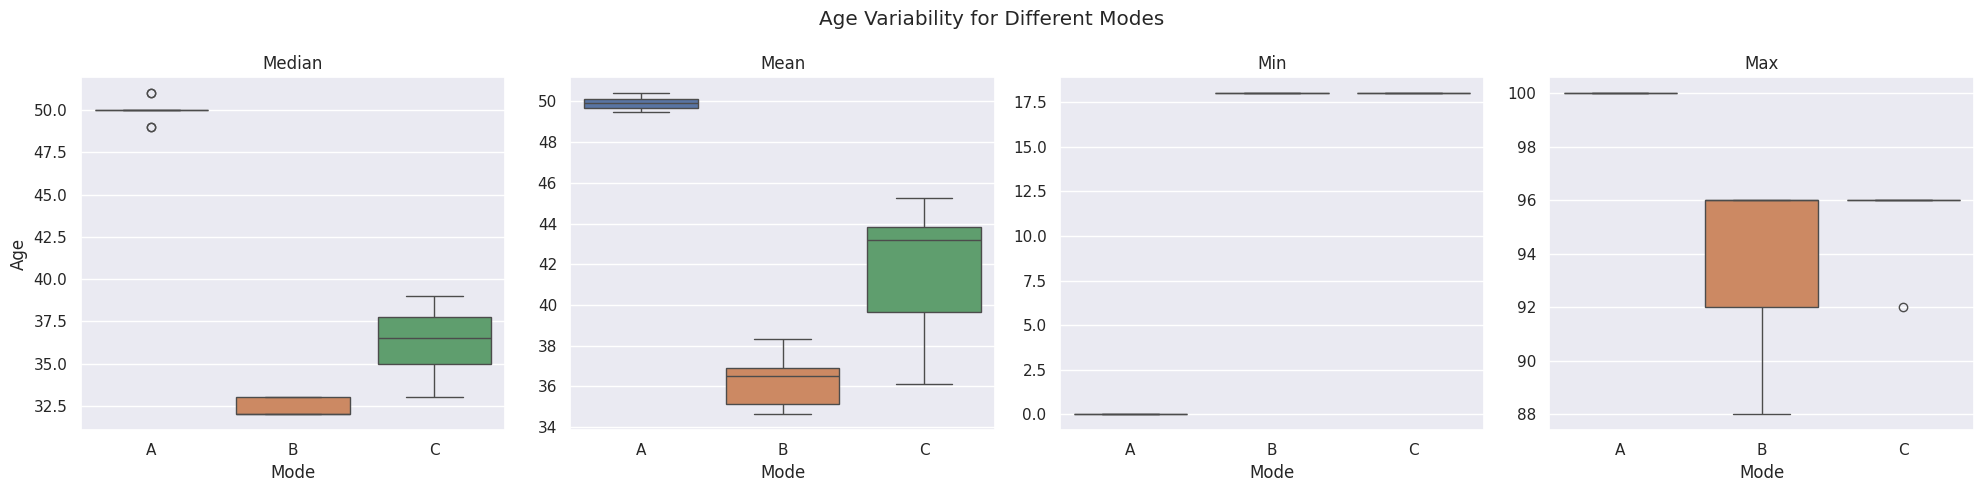

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Age Variability for Different Modes')
sns.boxplot(data=df_b[['median_A', 'median_B', 'median_C']], ax=axs[0])
axs[0].set_title('Median')
axs[0].set_ylabel('Age')
axs[0].set_xlabel('Mode')
axs[0].set_xticks(range(len(modes_b)))
axs[0].set_xticklabels(modes_b)
sns.boxplot(data=df_b[['mean_A', 'mean_B', 'mean_C']], ax=axs[1])
axs[1].set_title('Mean')
axs[1].set_xlabel('Mode')
axs[1].set_xticks(range(len(modes_b)))
axs[1].set_xticklabels(modes_b)
sns.boxplot(data=df_b[['min_A', 'min_B', 'min_C']], ax=axs[2])
axs[2].set_title('Min')
axs[2].set_xlabel('Mode')
axs[2].set_xticks(range(len(modes_b)))
axs[2].set_xticklabels(modes_b)
sns.boxplot(data=df_b[['max_A', 'max_B', 'max_C']], ax=axs[3])
axs[3].set_title('Max')
axs[3].set_xlabel('Mode')
axs[3].set_xticks(range(len(modes_b)))
axs[3].set_xticklabels(modes_b)
plt.tight_layout()
plt.show()

## Part (c)

Study how accuracy of Q3 changes for case **C**, as you vary __epsilon__ = [0.01, 0.02, ..., 0.1].

In [18]:
epsilons_mst_kl = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
iters = 5
# Your code here
modes_c = ['B', 'C', 'D']
df_c_kl_b = pd.DataFrame(columns=epsilons_mst_kl)
df_c_kl_c = pd.DataFrame(columns=epsilons_mst_kl)
df_c_kl_d = pd.DataFrame(columns=epsilons_mst_kl)
for seed in random_seeds:
    for epsilon in epsilons_mst_kl:
        df_real_B_temp = generate_data_B(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
        df_real_C_temp = generate_data_C(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
        df_real_D_temp = generate_data_D(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
        KL_B_temp = kl_test(df_real, df_real_B_temp, 'race')
        KL_C_temp = kl_test(df_real, df_real_C_temp, 'race')
        KL_D_temp = kl_test(df_real, df_real_D_temp, 'race')
        df_c_kl_b.loc[f'Seed_{seed}', epsilon] = KL_B_temp
        df_c_kl_c.loc[f'Seed_{seed}', epsilon] = KL_C_temp
        df_c_kl_d.loc[f'Seed_{seed}', epsilon] = KL_D_temp
clear_output()

In [19]:
df_c_kl_b

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
Seed_100,0.423469,0.190339,0.115275,0.077233,0.055388,0.045978,0.035058,0.027733,0.023762,0.020936
Seed_200,0.117204,0.074344,0.067489,0.064639,0.030967,0.020704,0.016279,0.012708,0.011114,0.008965
Seed_300,0.11787,0.049586,0.020592,0.010886,0.006656,0.005518,0.004132,0.003406,0.002979,0.002217
Seed_400,0.178612,0.058044,0.032391,0.022452,0.017176,0.013304,0.010927,0.009861,0.008796,0.008055
Seed_500,0.011166,0.005693,0.004583,0.00421,0.004053,0.004006,0.003873,0.003063,0.002148,0.001666
Seed_600,0.157373,0.068276,0.040984,0.029318,0.024312,0.019997,0.016893,0.014653,0.012394,0.007752
Seed_700,0.265392,0.131726,0.076491,0.043055,0.03403,0.021553,0.018628,0.015563,0.013037,0.01181
Seed_800,0.197809,0.075317,0.044002,0.026197,0.021721,0.017196,0.014149,0.012928,0.012328,0.011084
Seed_900,0.086325,0.072772,0.035492,0.019343,0.014203,0.009488,0.006299,0.004193,0.00444,0.004448
Seed_1000,0.112686,0.037416,0.021497,0.015751,0.012976,0.011596,0.010806,0.010211,0.009797,0.009571


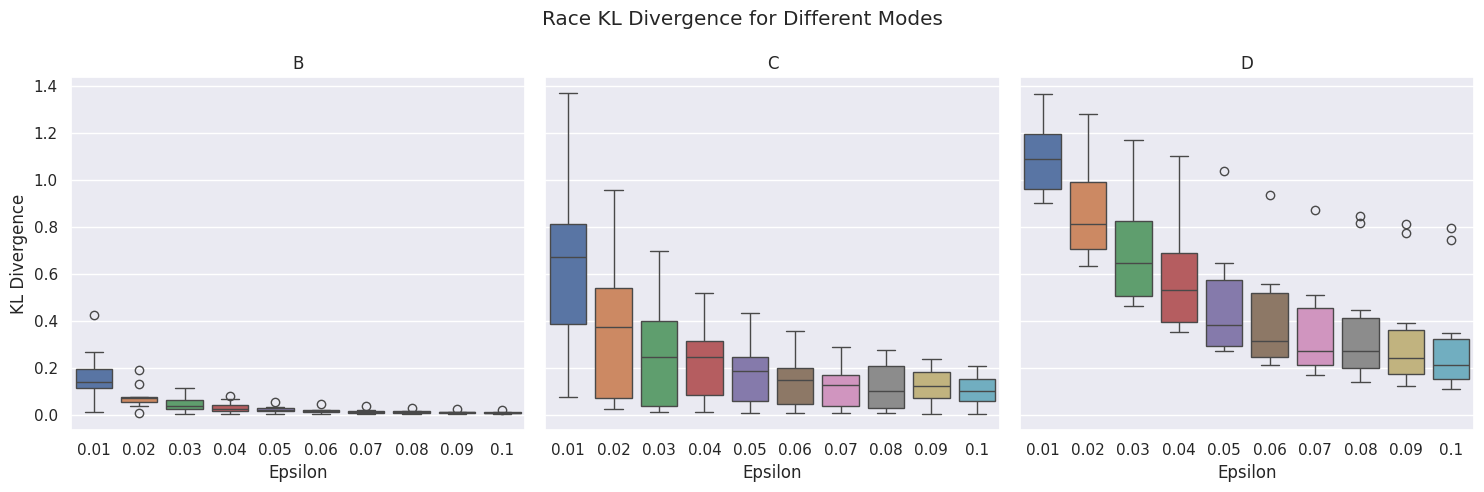

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Race KL Divergence for Different Modes')
sns.boxplot(data=df_c_kl_b, ax=axs[0])
axs[0].set_title('B')
axs[0].set_ylabel('KL Divergence')
axs[0].set_xlabel('Epsilon')
axs[0].set_xticks(range(len(epsilons_mst_kl)))
axs[0].set_xticklabels(epsilons_mst_kl)
sns.boxplot(data=df_c_kl_c, ax=axs[1])
axs[1].set_title('C')
axs[1].set_xlabel('Epsilon')
axs[1].set_xticks(range(len(epsilons_mst_kl)))
axs[1].set_xticklabels(epsilons_mst_kl)
sns.boxplot(data=df_c_kl_d, ax=axs[2])
axs[2].set_title('D')
axs[2].set_xlabel('Epsilon')
axs[2].set_xticks(range(len(epsilons_mst_kl)))
axs[2].set_xticklabels(epsilons_mst_kl)
plt.tight_layout()

#### Mutual Information Plot for MST
Again, replicate your plots from Part (c) for MST, this time for mutual information, on both hw_compas and hw_fake (df_real and df_fake), varying epsilon = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]. Compare this plot to the plot of dataset **D** (df_real_D). Once again, you need only generate **5 datasets** per epsilon (i.e., run 5 iterations per epsilon).

In [22]:
epsilons_mst_mi = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
iters = 5
# Your code here
mi_real = pairwise_attributes_mutual_information(df_real)

In [23]:
# Define a function to calculate the sum of the absolute value of differences
# between the pairwise mutual information of the real and synthetic data
def mi_diff_sum(mi1, mi2):
    sum_diff = 0
    for i in range(mi1.shape[0]):
        for j in range(mi1.shape[1]):
            # Calculate the absolute difference between corresponding elements
            abs_diff = abs(mi1.iloc[i, j] - mi2.iloc[i, j])
            # Add the absolute difference to the sum
            sum_diff += abs_diff
    # Return the sum of absolute differences divided by 2
    return sum_diff/2

In [24]:
df_c_mi_real = pd.DataFrame()
df_c_mi_fake = pd.DataFrame()
df_c_mi_diff = pd.DataFrame()
for mode in modes_c:
    for epsilon in epsilons_mst_mi:
        df_c_mi_real[f'{mode}_{epsilon}'] = None
        df_c_mi_fake[f'{mode}_{epsilon}'] = None
        df_c_mi_diff[f'{mode}_{epsilon}'] = None

In [25]:
df_c_mi_real

,B_0.0001,B_0.001,B_0.01,B_0.1,B_1,B_10,B_100,C_0.0001,C_0.001,C_0.01,...,C_1,C_10,C_100,D_0.0001,D_0.001,D_0.01,D_0.1,D_1,D_10,D_100


In [31]:
for seed in random_seeds:
    for epsilon in epsilons_mst_mi:
        for i, file in enumerate([real_data_file, fake_data_file]):
            df_B_temp = generate_data_B(file, output_data_size, epsilon=epsilon, seed=seed)
            df_C_temp = generate_data_C(file, output_data_size, epsilon=epsilon, seed=seed)
            df_D_temp = generate_data_D(file, output_data_size, epsilon=epsilon, seed=seed)
            mi_B_temp = pairwise_attributes_mutual_information(df_B_temp)
            mi_C_temp = pairwise_attributes_mutual_information(df_C_temp)
            mi_D_temp = pairwise_attributes_mutual_information(df_D_temp)
            if (i == 0):
                df_c_mi_real.loc[f'Seed_{seed}', f'B_{epsilon}'] = mi_diff_sum(mi_real, mi_B_temp)
                df_c_mi_real.loc[f'Seed_{seed}', f'C_{epsilon}'] = mi_diff_sum(mi_real, mi_C_temp)
                df_c_mi_real.loc[f'Seed_{seed}', f'D_{epsilon}'] = mi_diff_sum(mi_real, mi_D_temp)
                real_mi_temp = [mi_B_temp, mi_C_temp, mi_D_temp]
            else:
                df_c_mi_fake.loc[f'Seed_{seed}', f'B_{epsilon}'] = mi_diff_sum(mi_fake, mi_B_temp)
                df_c_mi_fake.loc[f'Seed_{seed}', f'C_{epsilon}'] = mi_diff_sum(mi_fake, mi_C_temp)
                df_c_mi_fake.loc[f'Seed_{seed}', f'D_{epsilon}'] = mi_diff_sum(mi_fake, mi_D_temp)
                fake_mi_temp = [mi_B_temp, mi_C_temp, mi_D_temp]
        for i in range(3):
            df_c_mi_diff.loc[f'Seed_{seed}', f'B_{epsilon}'] = mi_diff_sum(real_mi_temp[i], fake_mi_temp[i])
            df_c_mi_diff.loc[f'Seed_{seed}', f'C_{epsilon}'] = mi_diff_sum(real_mi_temp[i], fake_mi_temp[i])
            df_c_mi_diff.loc[f'Seed_{seed}', f'D_{epsilon}'] = mi_diff_sum(real_mi_temp[i], fake_mi_temp[i])
clear_output()

In [32]:
df_c_mi_real

,B_0.0001,B_0.001,B_0.01,B_0.1,B_1,B_10,B_100,C_0.0001,C_0.001,C_0.01,...,C_1,C_10,C_100,D_0.0001,D_0.001,D_0.01,D_0.1,D_1,D_10,D_100
Seed_100,0.107583,0.106595,0.100212,0.09658,0.095618,0.094918,0.094933,0.925535,0.960616,0.871136,...,0.012634,0.005084,0.005729,0.375056,0.375744,0.341348,0.190389,0.04489,0.012946,0.005733
Seed_200,0.106643,0.10592,0.099059,0.094699,0.093663,0.094736,0.094774,0.909487,0.849163,0.523261,...,0.018677,0.009723,0.009314,0.339138,0.333674,0.308505,0.178601,0.034575,0.012597,0.011106
Seed_300,0.111635,0.109315,0.099928,0.093955,0.09417,0.094497,0.094417,0.890579,1.069627,0.602992,...,0.012665,0.007093,0.008039,0.562155,0.548866,0.425385,0.101647,0.041943,0.007755,0.007598
Seed_400,0.103479,0.106201,0.098888,0.09465,0.093778,0.095147,0.09486,0.745717,0.736783,0.737612,...,0.027066,0.007812,0.008285,0.45322,0.440888,0.39823,0.141187,0.043792,0.012585,0.009569
Seed_500,0.106976,0.104588,0.100598,0.097207,0.095347,0.09601,0.09604,0.872055,0.822014,0.552599,...,0.015116,0.005869,0.0064,0.485225,0.473187,0.395615,0.17025,0.046561,0.012584,0.008189
Seed_600,0.10493,0.102131,0.099244,0.095399,0.093828,0.094612,0.094565,1.633816,1.623868,1.291945,...,0.011674,0.005449,0.004005,0.504883,0.49177,0.430582,0.136869,0.011333,0.01245,0.006292
Seed_700,0.106914,0.102963,0.099703,0.093151,0.09472,0.094923,0.09473,0.824983,0.715714,0.424287,...,0.023288,0.011772,0.008068,0.313332,0.309941,0.269888,0.151467,0.043,0.015154,0.010644
Seed_800,0.110437,0.106493,0.104034,0.097191,0.097251,0.094996,0.095107,1.835299,1.678345,0.685936,...,0.018117,0.007258,0.005345,0.267795,0.265638,0.251261,0.144942,0.040496,0.01557,0.009579
Seed_900,0.1113,0.110663,0.102964,0.095519,0.096062,0.096362,0.096742,1.02486,0.981581,0.652556,...,0.021429,0.005598,0.004127,0.374823,0.368657,0.341478,0.071845,0.038791,0.011089,0.006285
Seed_1000,0.110743,0.109475,0.102914,0.097258,0.096692,0.098342,0.098767,0.561417,0.57626,0.459585,...,0.026525,0.007562,0.004793,0.334238,0.329386,0.305236,0.198003,0.052643,0.0138,0.006366


In [34]:
df_c_mi_fake

,B_0.0001,B_0.001,B_0.01,B_0.1,B_1,B_10,B_100,C_0.0001,C_0.001,C_0.01,...,C_1,C_10,C_100,D_0.0001,D_0.001,D_0.01,D_0.1,D_1,D_10,D_100
Seed_100,2.027509,2.027431,1.032418,1.031672,1.031962,1.031995,1.032002,0.645388,0.642295,0.745635,...,0.40781,0.37738,0.327734,0.552466,0.541717,0.493069,0.350164,0.093668,0.014461,0.013838
Seed_200,1.640539,1.640646,1.032,1.032204,1.031612,1.031532,1.031589,0.977573,0.960805,0.913819,...,0.415842,0.399044,0.320616,0.56592,0.573306,0.616548,0.629914,0.198022,0.056384,0.034712
Seed_300,1.640938,1.640942,1.03267,1.031699,1.031754,1.031855,1.031773,2.15295,2.116749,0.937368,...,0.442511,0.359214,0.322603,0.57325,0.570273,0.570926,0.548658,0.063605,0.026793,0.018855
Seed_400,1.032734,1.032702,1.032588,1.031499,1.031981,1.031947,1.03198,1.088617,1.062269,1.142988,...,0.325159,0.326125,0.326502,0.49369,0.497055,0.492012,0.672023,0.299256,0.200057,0.025782
Seed_500,1.631467,2.817237,1.032556,1.031607,1.031282,1.031297,1.03132,1.376344,1.303723,0.790804,...,0.353707,0.332168,0.314434,0.849144,0.826997,0.702759,0.695574,0.216962,0.191975,0.178455
Seed_600,1.610354,1.610295,2.817237,1.031999,1.031695,1.031534,1.031509,1.115527,1.121964,1.170752,...,0.354126,0.32002,0.3128,0.866127,0.851004,0.71816,0.329701,0.19311,0.01107,0.009949
Seed_700,1.032575,1.03266,1.032471,1.031844,1.032101,1.031987,1.032028,1.064819,1.068655,1.07622,...,0.623096,0.429539,0.332529,0.473581,0.477968,0.504856,0.559865,0.251818,0.059069,0.046489
Seed_800,1.641038,1.03276,1.032461,1.031381,1.031352,1.031362,1.03137,1.181456,1.178746,0.884014,...,0.440362,0.369373,0.405012,0.760876,0.758727,0.706924,0.543654,0.057126,0.028147,0.027159
Seed_900,2.028019,2.028001,1.032562,1.032011,1.031901,1.032005,1.031959,0.57263,0.580213,0.610079,...,0.383339,0.407663,0.31224,0.512715,0.508822,0.523835,0.503024,0.06905,0.013726,0.019751
Seed_1000,1.032596,1.032476,1.032871,1.03193,1.032221,1.032185,1.032176,2.541803,2.481479,1.346173,...,0.4381,0.32966,0.31528,0.63961,0.640265,0.632662,0.613921,0.097212,0.187127,0.183906


In [35]:
df_c_mi_diff

,B_0.0001,B_0.001,B_0.01,B_0.1,B_1,B_10,B_100,C_0.0001,C_0.001,C_0.01,...,C_1,C_10,C_100,D_0.0001,D_0.001,D_0.01,D_0.1,D_1,D_10,D_100
Seed_100,0.950955,0.950263,0.922447,0.556829,0.826267,0.898122,0.915725,0.950955,0.950263,0.922447,...,0.826267,0.898122,0.915725,0.950955,0.950263,0.922447,0.556829,0.826267,0.898122,0.915725
Seed_200,0.4378,0.429461,0.414163,0.466573,0.697865,0.857461,0.882683,0.4378,0.429461,0.414163,...,0.697865,0.857461,0.882683,0.4378,0.429461,0.414163,0.466573,0.697865,0.857461,0.882683
Seed_300,0.391932,0.362055,0.391691,0.756892,0.84444,0.904591,0.918441,0.391932,0.362055,0.391691,...,0.84444,0.904591,0.918441,0.391932,0.362055,0.391691,0.756892,0.84444,0.904591,0.918441
Seed_400,0.397901,0.38849,0.379379,0.360473,0.658419,0.738979,0.88775,0.397901,0.38849,0.379379,...,0.658419,0.738979,0.88775,0.397901,0.38849,0.379379,0.360473,0.658419,0.738979,0.88775
Seed_500,1.023512,1.006344,0.805784,0.725915,0.678787,0.730894,0.750653,1.023512,1.006344,0.805784,...,0.678787,0.730894,0.750653,1.023512,1.006344,0.805784,0.725915,0.678787,0.730894,0.750653
Seed_600,1.082029,1.080082,0.966052,0.622131,0.718568,0.90309,0.909524,1.082029,1.080082,0.966052,...,0.718568,0.90309,0.909524,1.082029,1.080082,0.966052,0.622131,0.718568,0.90309,0.909524
Seed_700,0.505163,0.498486,0.40694,0.351152,0.64398,0.856223,0.874908,0.505163,0.498486,0.40694,...,0.64398,0.856223,0.874908,0.505163,0.498486,0.40694,0.351152,0.64398,0.856223,0.874908
Seed_800,1.07517,1.070977,1.00862,0.908865,0.838176,0.932763,0.935267,1.07517,1.070977,1.00862,...,0.838176,0.932763,0.935267,1.07517,1.070977,1.00862,0.908865,0.838176,0.932763,0.935267
Seed_900,0.924913,0.926376,0.917229,0.854394,0.832896,0.906041,0.907541,0.924913,0.926376,0.917229,...,0.832896,0.906041,0.907541,0.924913,0.926376,0.917229,0.854394,0.832896,0.906041,0.907541
Seed_1000,0.716557,0.710488,0.733406,0.825285,0.789572,0.726938,0.734715,0.716557,0.710488,0.733406,...,0.789572,0.726938,0.734715,0.716557,0.710488,0.733406,0.825285,0.789572,0.726938,0.734715


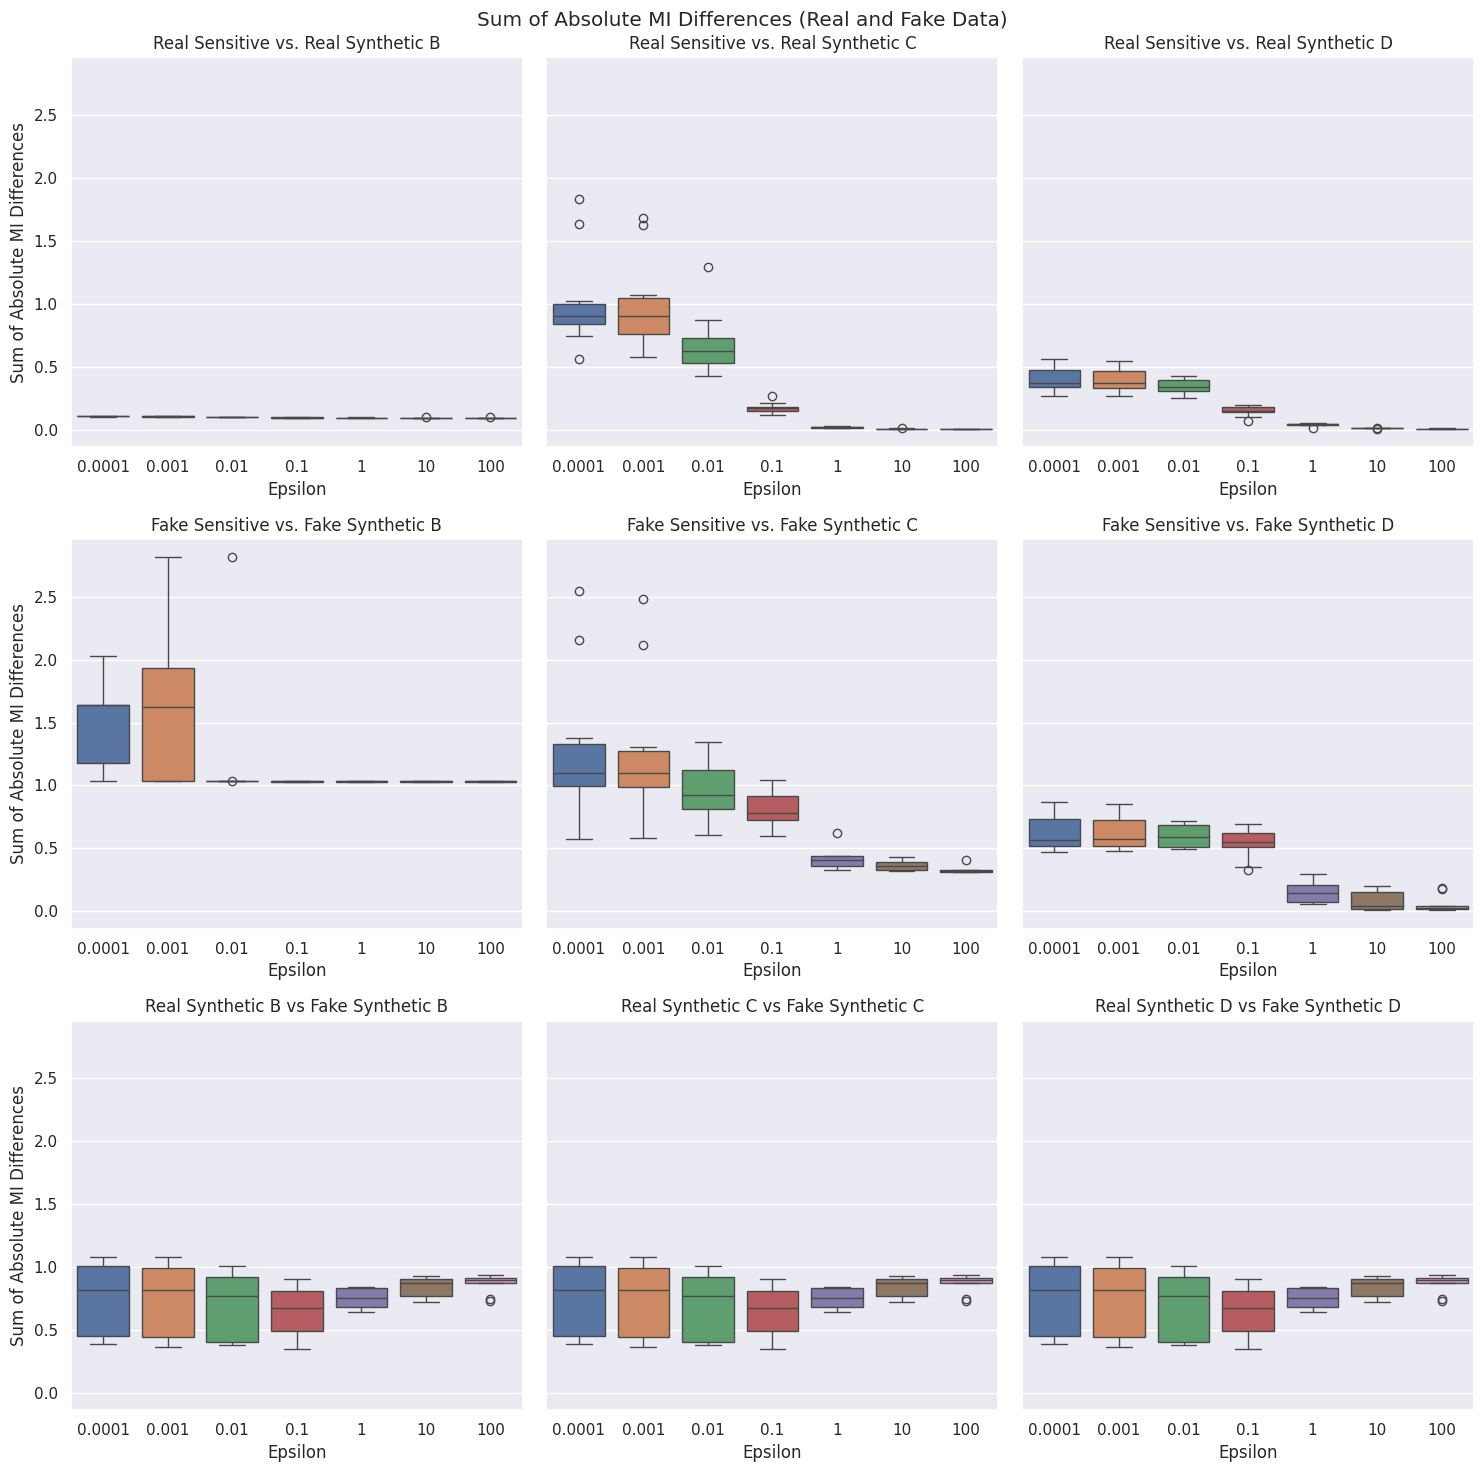

In [38]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Sum of Absolute MI Differences (Real and Fake Data)')
sns.boxplot(data=df_c_mi_real.iloc[:,0:7], ax=axs[0, 0])
axs[0, 0].set_title('Real Sensitive vs. Real Synthetic B')
axs[0, 0].set_ylabel('Sum of Absolute MI Differences')
axs[0, 0].set_xlabel('Epsilon')
axs[0, 0].set_xticks(range(len(epsilons_mst_mi)))
axs[0, 0].set_xticklabels(epsilons_mst_mi)
sns.boxplot(data=df_c_mi_real.iloc[:,7:14], ax=axs[0, 1])
axs[0, 1].set_title('Real Sensitive vs. Real Synthetic C')
axs[0, 1].set_xlabel('Epsilon')
axs[0, 1].set_xticks(range(len(epsilons_mst_mi)))
axs[0, 1].set_xticklabels(epsilons_mst_mi)
sns.boxplot(data=df_c_mi_real.iloc[:,14:21], ax=axs[0, 2])
axs[0, 2].set_title('Real Sensitive vs. Real Synthetic D')
axs[0, 2].set_xlabel('Epsilon')
axs[0, 2].set_xticks(range(len(epsilons_mst_mi)))
axs[0, 2].set_xticklabels(epsilons_mst_mi)

sns.boxplot(data=df_c_mi_fake.iloc[:,0:7], ax=axs[1, 0])
axs[1, 0].set_title('Fake Sensitive vs. Fake Synthetic B')
axs[1, 0].set_ylabel('Sum of Absolute MI Differences')
axs[1, 0].set_xlabel('Epsilon')
axs[1, 0].set_xticks(range(len(epsilons_mst_mi)))
axs[1, 0].set_xticklabels(epsilons_mst_mi)
sns.boxplot(data=df_c_mi_fake.iloc[:,7:14], ax=axs[1, 1])
axs[1, 1].set_title('Fake Sensitive vs. Fake Synthetic C')
axs[1, 1].set_xlabel('Epsilon')
axs[1, 1].set_xticks(range(len(epsilons_mst_mi)))
axs[1, 1].set_xticklabels(epsilons_mst_mi)
sns.boxplot(data=df_c_mi_fake.iloc[:,14:21], ax=axs[1, 2])
axs[1, 2].set_title('Fake Sensitive vs. Fake Synthetic D')
axs[1, 2].set_xlabel('Epsilon')
axs[1, 2].set_xticks(range(len(epsilons_mst_mi)))
axs[1, 2].set_xticklabels(epsilons_mst_mi)

sns.boxplot(data=df_c_mi_diff.iloc[:,0:7], ax=axs[2, 0])
axs[2, 0].set_title('Real Synthetic B vs Fake Synthetic B')
axs[2, 0].set_ylabel('Sum of Absolute MI Differences')
axs[2, 0].set_xlabel('Epsilon')
axs[2, 0].set_xticks(range(len(epsilons_mst_mi)))
axs[2, 0].set_xticklabels(epsilons_mst_mi)
sns.boxplot(data=df_c_mi_diff.iloc[:,7:14], ax=axs[2, 1])
axs[2, 1].set_title('Real Synthetic C vs Fake Synthetic C')
axs[2, 1].set_xlabel('Epsilon')
axs[2, 1].set_xticks(range(len(epsilons_mst_mi)))
axs[2, 1].set_xticklabels(epsilons_mst_mi)
sns.boxplot(data=df_c_mi_diff.iloc[:,14:21], ax=axs[2, 2])
axs[2, 2].set_title('Real Synthetic D vs Fake Synthetic D')
axs[2, 2].set_xlabel('Epsilon')
axs[2, 2].set_xticks(range(len(epsilons_mst_mi)))
axs[2, 2].set_xticklabels(epsilons_mst_mi)
plt.tight_layout()